In [1]:
import numpy as np
import h5py

from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply
from keras.layers import BatchNormalization,LeakyReLU,Flatten,Embedding
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Sequential, Model
from keras.optimizers import Adam

from sklearn.utils import shuffle


from pre_prop_func import play_spec

Using TensorFlow backend.


In [2]:
z_dim = 100
x_shape = (240,512,1)
alpha = 0.0001
beta1 = 0.5
beta2 = 0.9
s_factor = 5/2
target_classes = 10 
losses = ['binary_crossentropy','sparse_categorical_crossentropy']

In [3]:
adams = Adam(lr = alpha, beta_1 = beta1, beta_2 = beta2)

In [4]:
def discriminator():
    
    model = Sequential()
    
    model.add(Conv2D(1,kernel_size = 4,strides = 2,input_shape = x_shape))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(2,kernel_size = 5,strides = 2))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(4,kernel_size = 4,strides = 2))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(8,kernel_size = 4,strides = 2))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(16,kernel_size = (5,4),strides = 2))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    
    x_in = Input(shape=x_shape)
    conv_out = model(x_in)
    
    validity = Dense(1,activation = 'sigmoid')(conv_out)
    predict = Dense(target_classes+1,activation = 'softmax')(conv_out)
    
    
    disr = Model(x_in,[validity,predict])  
    return disr

In [5]:
def generator():
    
    model = Sequential()
    
    model.add(Dense(1120,activation = "relu",input_dim = z_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Reshape((5,14,16)))
    model.add(Deconv2d(16,kernel_size = (5,4),activation = "relu",strides = 2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.25))
    model.add(Deconv2d(8,kernel_size = 4,activation = "relu",strides = 2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Deconv2d(4,kernel_size = 4,activation = "relu",strides = 2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.25))
    model.add(Deconv2d(2,kernel_size = 5,activation = "relu",strides= 2,input_shape = (58,126,2)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Deconv2d(1,kernel_size = 4,activation = "tanh",strides = 2))
        
    z_in = Input(shape=(z_dim,))
    class_in = Input(shape=(1,), dtype = 'int32')
    
    embedding = Embedding(target_classes,z_dim)(class_in)
    label_embedding = Reshape((100,))(embedding)
    model_in = multiply([z_in,label_embedding])
    
    out_gen = model(model_in)
    
    genr = Model([z_in,class_in],out_gen)
    
    return genr

In [6]:
gen = generator()
dis = discriminator()

z = Input(shape=(z_dim,))
labels_in = Input(shape=(1,),dtype = 'int32')
g_z = gen([z,labels_in])
d_g_z,d_g_z_l = dis(g_z)

combined = Model([z,labels_in],[d_g_z,d_g_z_l])

dis.compile(loss = losses, optimizer = adams)
combined.compile(loss = losses, optimizer = adams)

In [7]:
gen.summary()
dis.summary()
combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

In [8]:
D_Loss = []
G_Loss = []

In [35]:
epochs = 2
batch_size = 32
batches = 32
files = 10
data_file = []
label_file = []
dis_updates = 2
dis_updates_wrong = 1
gen_updates = 1
tens = np.full((32,), 10)
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates

In [49]:
if(True):

    gen.load_weights("generator_6.h5")
    dis.load_weights("discriminator_6.h5")

In [36]:


for epoch in range(epochs):
    
    print("##############")
    print("For Epoch:"+str(epoch))
    
    for i in range(files):
        
        d_loss = 0
        g_loss = 0
        
        path = "C:\\Users\\ADMIN\\Desktop\\Voice_transformation\\Data Preprocessing\\inputs_" + str(i) + ".h5"
        with h5py.File(path,"r") as f:
            data_file = np.asarray(f["data"])
            label_file = np.asarray(f["label"])
        data_file = data_file.reshape(1024,240,512,1)/s_factor + 1
        
        dis.trainable = True
        
        dis.compile(loss = losses, optimizer = adams)
        combined.compile(loss = losses, optimizer = adams)
        
        print("Training Discriminator") 
        for j in range(dis_updates):
            
            for b in range(batches):
                x_batch = data_file[b*batch_size:batch_size*(b+1),:,:,:]
                y_batch = label_file[b*batch_size:batch_size*(b+1)]
                
                z_batch = np.random.normal(0,0.3,(32,100,))
                g_z_batch = gen.predict([z_batch,y_batch])
                                
                d_loss += dis.train_on_batch(x_batch,[np.ones((32,1)),y_batch])[0]
                d_loss += dis.train_on_batch(g_z_batch,[np.zeros((32,1)),tens])[0]
                
                del x_batch
                del y_batch
                del z_batch
                del g_z_batch
                
        for j in range(dis_updates_wrong):
            
            for b in range(batches):
                x_batch = data_file[b*batch_size:batch_size*(b+1),:,:,:]
                y_batch = label_file[b*batch_size:batch_size*(b+1)]
                
                z_batch = np.random.normal(0,0.3,(32,100,))
                g_z_batch = gen.predict([z_batch,y_batch])
                                
                _ = dis.train_on_batch(g_z_batch,[np.ones((32,1)),y_batch])[0]
                _ = dis.train_on_batch(x_batch,[np.zeros((32,1)),tens])[0]
                
                del x_batch
                del y_batch
                del z_batch
                del g_z_batch
                      
        dis.trainable = False   
        
        dis.compile(loss = losses, optimizer = adams)
        combined.compile(loss = losses, optimizer = adams)
        
        print("Training Generator") 
                
        for j in range(gen_updates):
            
            for b in range(batches):
                
                z_batch = np.random.normal(0,0.3,(32,100,))                
                y_batch = label_file[b*batch_size:batch_size*(b+1)]
                
                g_loss += combined.train_on_batch([z_batch,y_batch],[np.ones((32,1)),y_batch])[0]
                
                del z_batch
                del y_batch
        
        d_loss = d_loss/d_loss_factor
        g_loss = g_loss/g_loss_factor
                
        print("File:" + str(i) + " done")
        print("G_loss:",g_loss)
        print("D_loss:",d_loss)
        
        data_file = None
        del data_file
        del label_file
        
        G_Loss.append(g_loss)
        D_Loss.append(d_loss)
        
    gen.save_weights("generator_"+str(epoch)+".h5")
    dis.save_weights("discriminator_"+str(epoch)+".h5")
    combined.save_weights("combined_"+str(epoch)+".h5")       
    print("###########\nModel Saved")

##############
For Epoch:0
Training Discriminator
Training Generator
File:0 done
G_loss: 1.0827727671712637
D_loss: 1.3411630123882787
Training Discriminator
Training Generator
File:1 done
G_loss: 1.12196359410882
D_loss: 1.208560122162453
Training Discriminator
Training Generator
File:2 done
G_loss: 1.0118712037801743
D_loss: 1.1347582663365756
Training Discriminator
Training Generator
File:3 done
G_loss: 0.9419830124825239
D_loss: 1.1012872610263003
Training Discriminator
Training Generator
File:4 done
G_loss: 0.8846079930663109
D_loss: 1.0558300366756157
Training Discriminator
Training Generator
File:5 done
G_loss: 0.9201396070420742
D_loss: 1.0840843514233711
Training Discriminator
Training Generator
File:6 done
G_loss: 0.8806420620530844
D_loss: 1.1030550194409443
Training Discriminator
Training Generator
File:7 done
G_loss: 0.8465714398771524
D_loss: 1.134775892183825
Training Discriminator
Training Generator
File:8 done
G_loss: 0.8399302549660206
D_loss: 1.119905531522818
Traini

In [53]:
z = np.random.normal(0,0.3,(1,100,))
a_y = np.full((1,),9)

In [54]:
my_spec = gen.predict([z,a_y])
print(dis.predict(my_spec))
my_spec = (my_spec - 1)*s_factor
play_spec(my_spec.reshape(240,512))

[array([[0.00261432]], dtype=float32), array([[1.1156273e-02, 4.3725693e-03, 1.1791444e-02, 6.3852947e-03,
        3.8300693e-04, 1.7986296e-03, 2.2617471e-04, 4.7774709e-04,
        2.7857800e-03, 1.6985722e-02, 9.4363731e-01]], dtype=float32)]


Text(0.5,1.05,'Original Spectrogram')

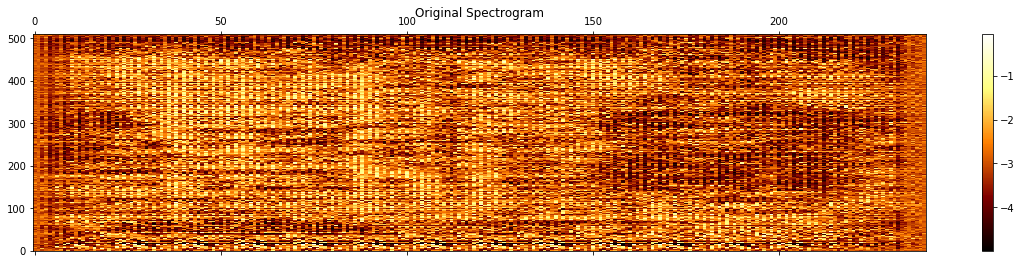

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(my_spec.reshape(240,512)), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')


NONE- loss 14,1.5
